# Test on MNIST dataset

In [150]:
%load_ext autoreload
%autoreload 2

from scripts.benchmark_functions import *
from scripts.train_functions import set_up_model
from mnist_demo.utils import *
import scod
import copy
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load trained model

In [151]:
# load_model_path = './best_model/mnist_model.pt'
# load_model_path = './best_model/overtrained_mnist_model.pt'
load_model_path = './best_model/mnist/best_model.pt'


model, optimizer, start_epoch_idx, valid_loss, criterion, device = load_model_from_ckp(load_model_path)

#### Evaluate trained model on 5 MNIST digits (drawn from mnist_test) and Fashion (drawn from fashion)

In [152]:
batch_size = 256
dataset_name = "mnist"

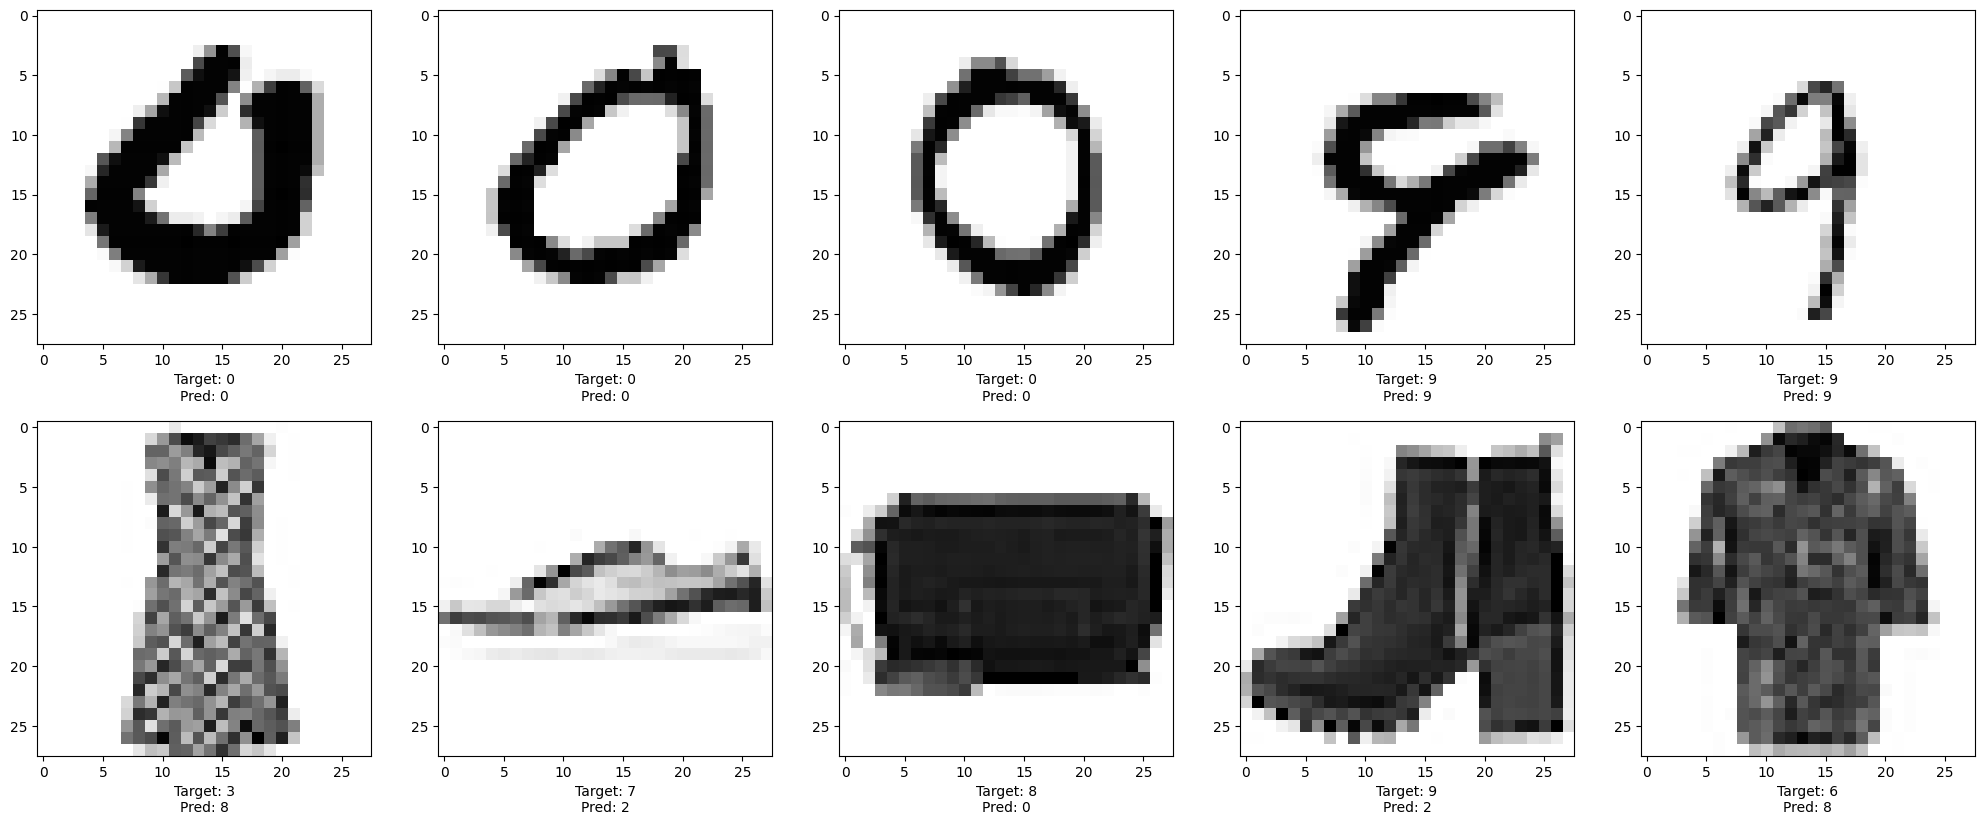

In [153]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model)

#### Add SCOD wrapper

In [154]:
unc_model = create_scod_model(load_model_path, dataset_name, batch_size)

Weight space dimension: 4.443e+04
computing basis
using T = 304


  0%|          | 0/188 [00:00<?, ?it/s]

#### Print SCOD uncertainties for MNIST digits

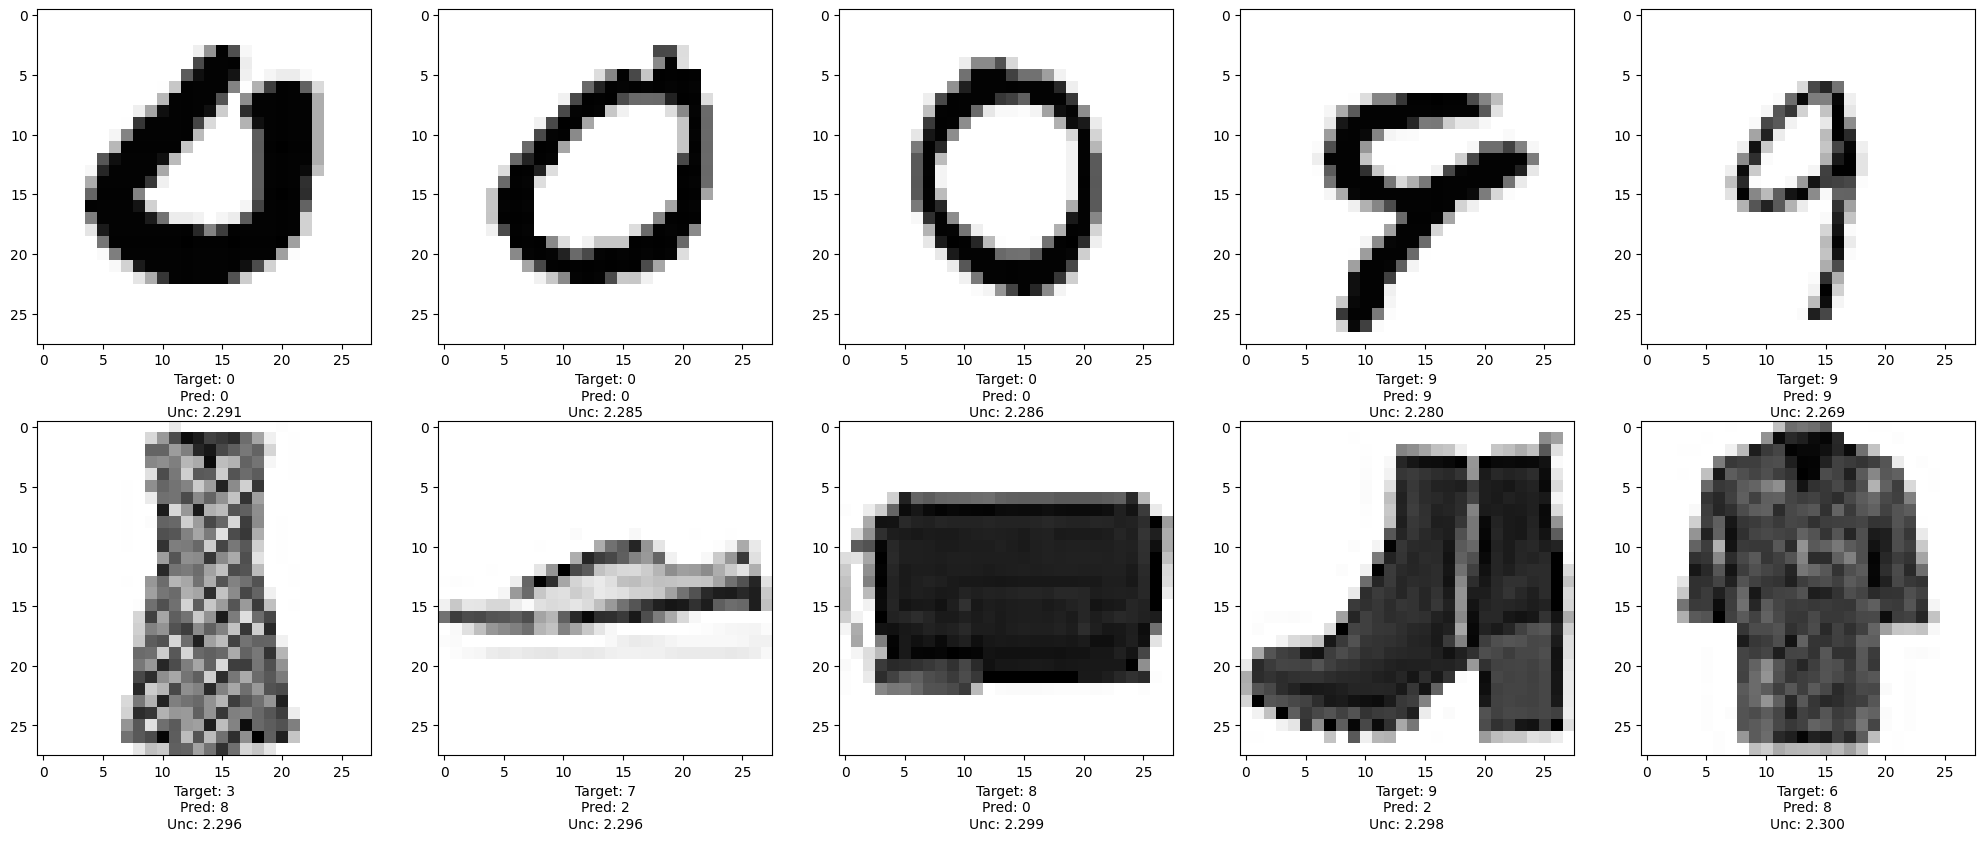

In [155]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model, unc_model=unc_model)

Question: Can SCOD detect the out-of-distribution images here?

#### ANSWER: Yes.

# Plot classification accuracy vs scod uncertainty

In [156]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

images = {'mnist_test':100, 'fashion':100}
images = {'mnist_test':100, 'emnist':100, 'fashion':100}

accs = {}
uncs = {}
losses = {}
np.random.seed(seed=11)
for dname in images:
    accs[dname] = np.zeros(images[dname])
    uncs[dname] = np.zeros(images[dname])
    losses[dname] = np.zeros(images[dname])
    idxs = np.random.choice(len(dataloaders[dname].dataset), images[dname])
    for i, idx in enumerate(idxs):
        input, target = (dataloaders[dname].dataset)[idx]
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if unc_model is not None:
            z_mean, z_var = unc_model(input.to(device).unsqueeze(0))
            pred = np.argmax(z_mean[0].detach().cpu().numpy())

            dist_layer = scod.distributions.CategoricalLogitLayer()
            unc = eval_scod(input, unc_model, dist_layer)
            unc = unc.item()

            accs[dname][i] = (pred==target)
            uncs[dname][i] = unc
        if model is not None:
            output = model(input.to(device).unsqueeze(0))
            dist = dist_layer(output.to(device))
            if target > 9:
                target = 9
            loss = -dist.log_prob(torch.tensor(target).to(device))
            mean_loss = loss.mean().item()
            losses[dname][i] = mean_loss


Text(0, 0.5, 'Losses')

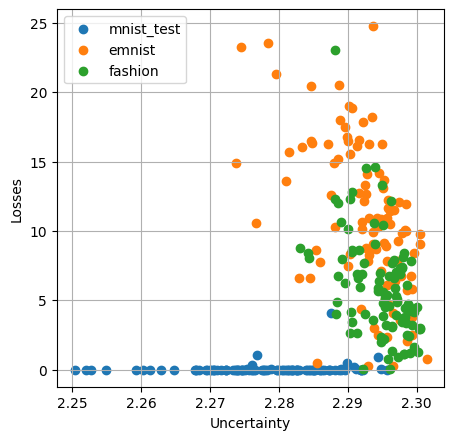

In [157]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(uncs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Uncertainty')
ax.set_ylabel('Losses')

Text(0.5, 0, 'Losses')

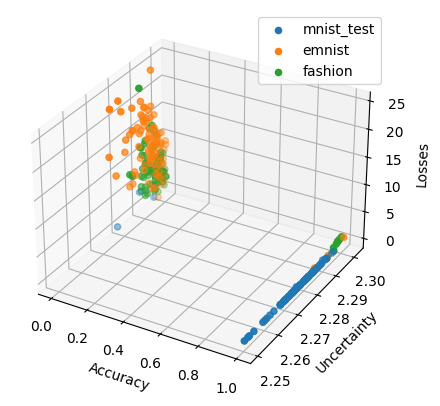

In [158]:
fig = plt.figure(figsize = [5,5], dpi=100)
ax = fig.add_subplot(projection='3d')
for dname in images:
    ax.scatter(accs[dname], uncs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Uncertainty')
ax.set_zlabel('Losses')

Text(0, 0.5, 'Uncertainty')

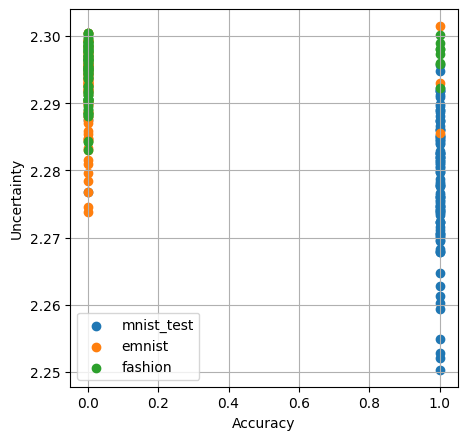

In [159]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(accs[dname], uncs[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Uncertainty')

Text(0, 0.5, 'Losses')

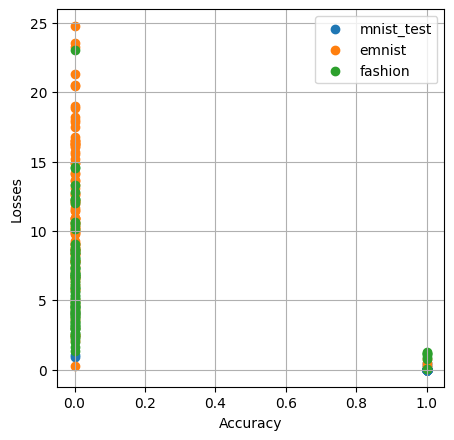

In [160]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(accs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Losses')

#### From a batch of mixed fashion + mnist, use scod-k highest and DS-SCOD to pull out 2 images to label

In [161]:
batch_size = 10
batch_compositions = [  {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5}
                        ]
# batch_compositions = [  {'mnist_test':5,'fashion':5}
#                         ]
num_batches = len(batch_compositions)

flag_limit = 2
algs_to_test = [lambda x: scod_flagger(x, unc_model, flag_limit=flag_limit, debug = False, dist_layer = scod.distributions.CategoricalLogitLayer()),
                lambda x: ds_scod_flagger(x, unc_model, flag_limit, debug=False, dist_layer = scod.distributions.CategoricalLogitLayer())]

Test seq  0  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, True, False]
Test seq  0  algorithm  1  flagged:  [False, True, False, False, False, False, False, False, True, False]
Test seq  1  algorithm  0  flagged:  [False, False, False, False, False, False, True, True, False, False]
Test seq  1  algorithm  1  flagged:  [False, False, False, False, False, False, False, True, True, False]
Test seq  2  algorithm  0  flagged:  [False, False, False, False, False, False, False, False, True, True]
Test seq  2  algorithm  1  flagged:  [False, False, False, False, False, True, False, False, False, True]
Test seq  3  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  3  algorithm  1  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  4  algorithm  0  flagged:  [False, False, False, False, False, True, False, False, False, True]
Test seq  4  algorithm  1  flagged:  [False, F

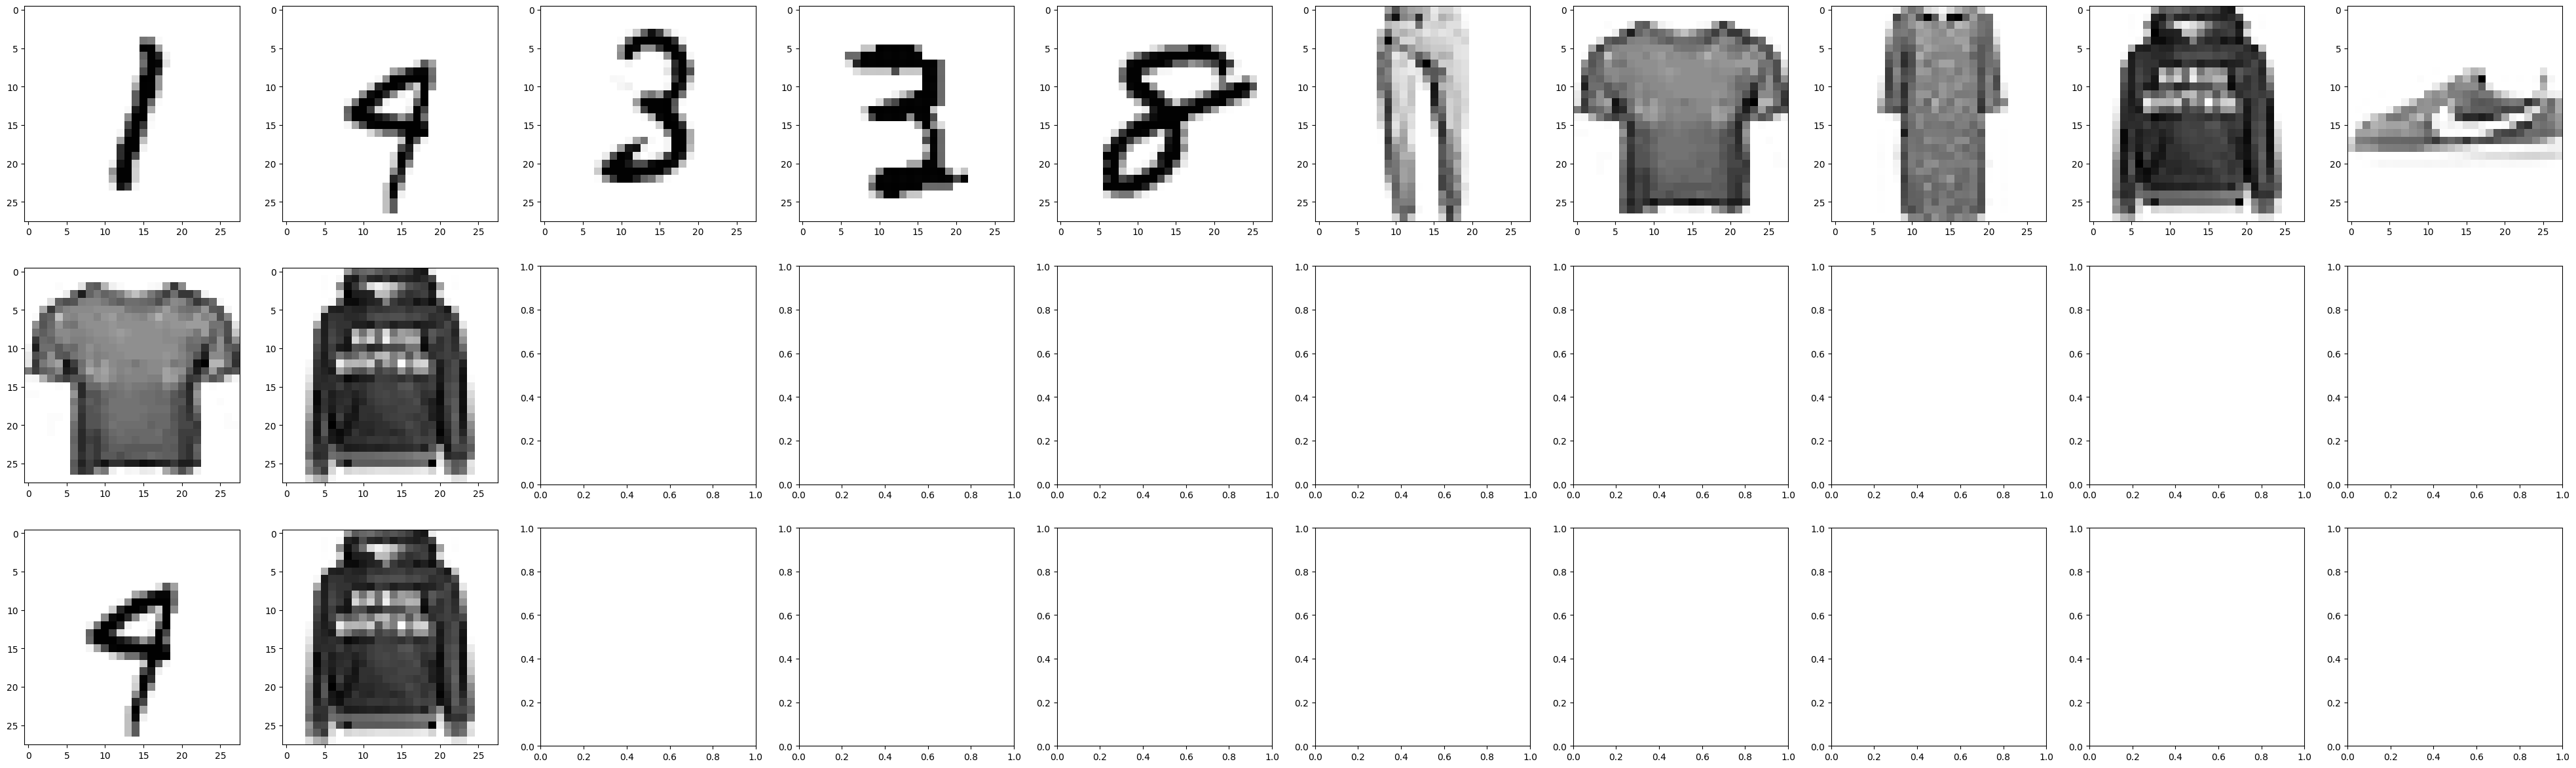

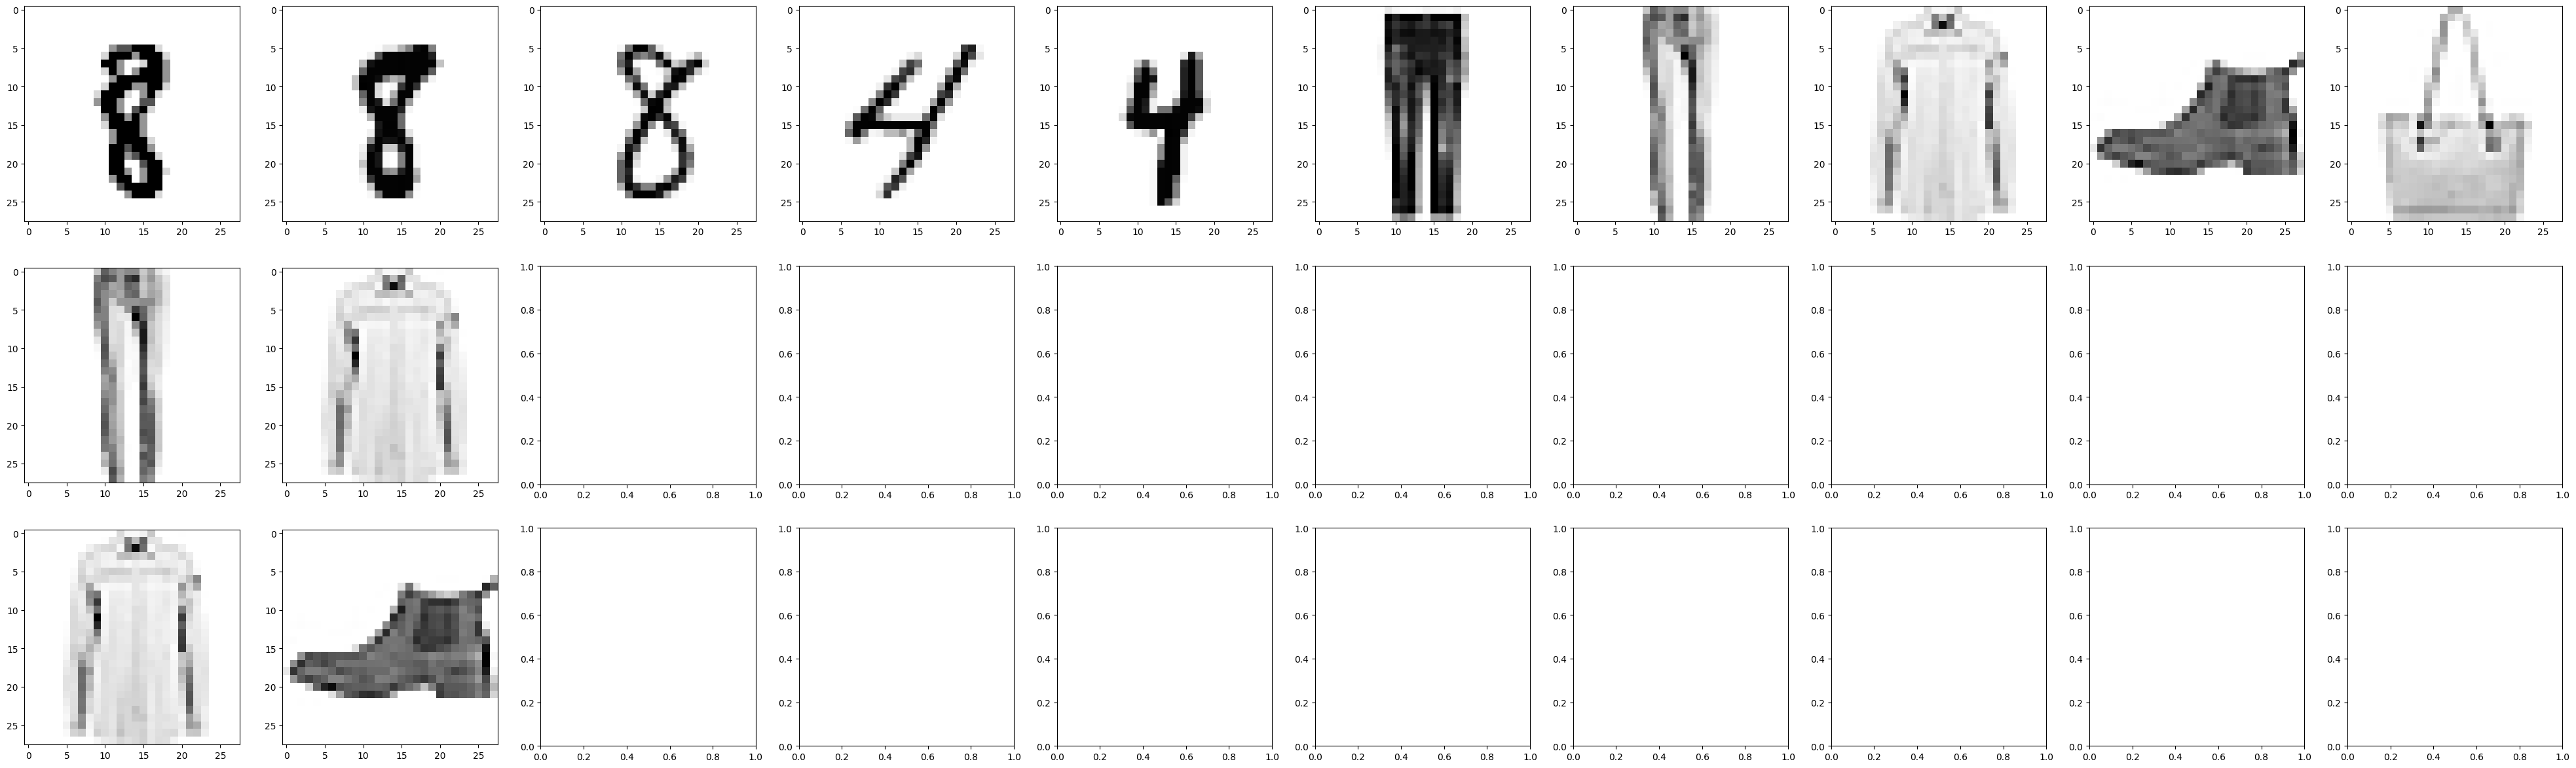

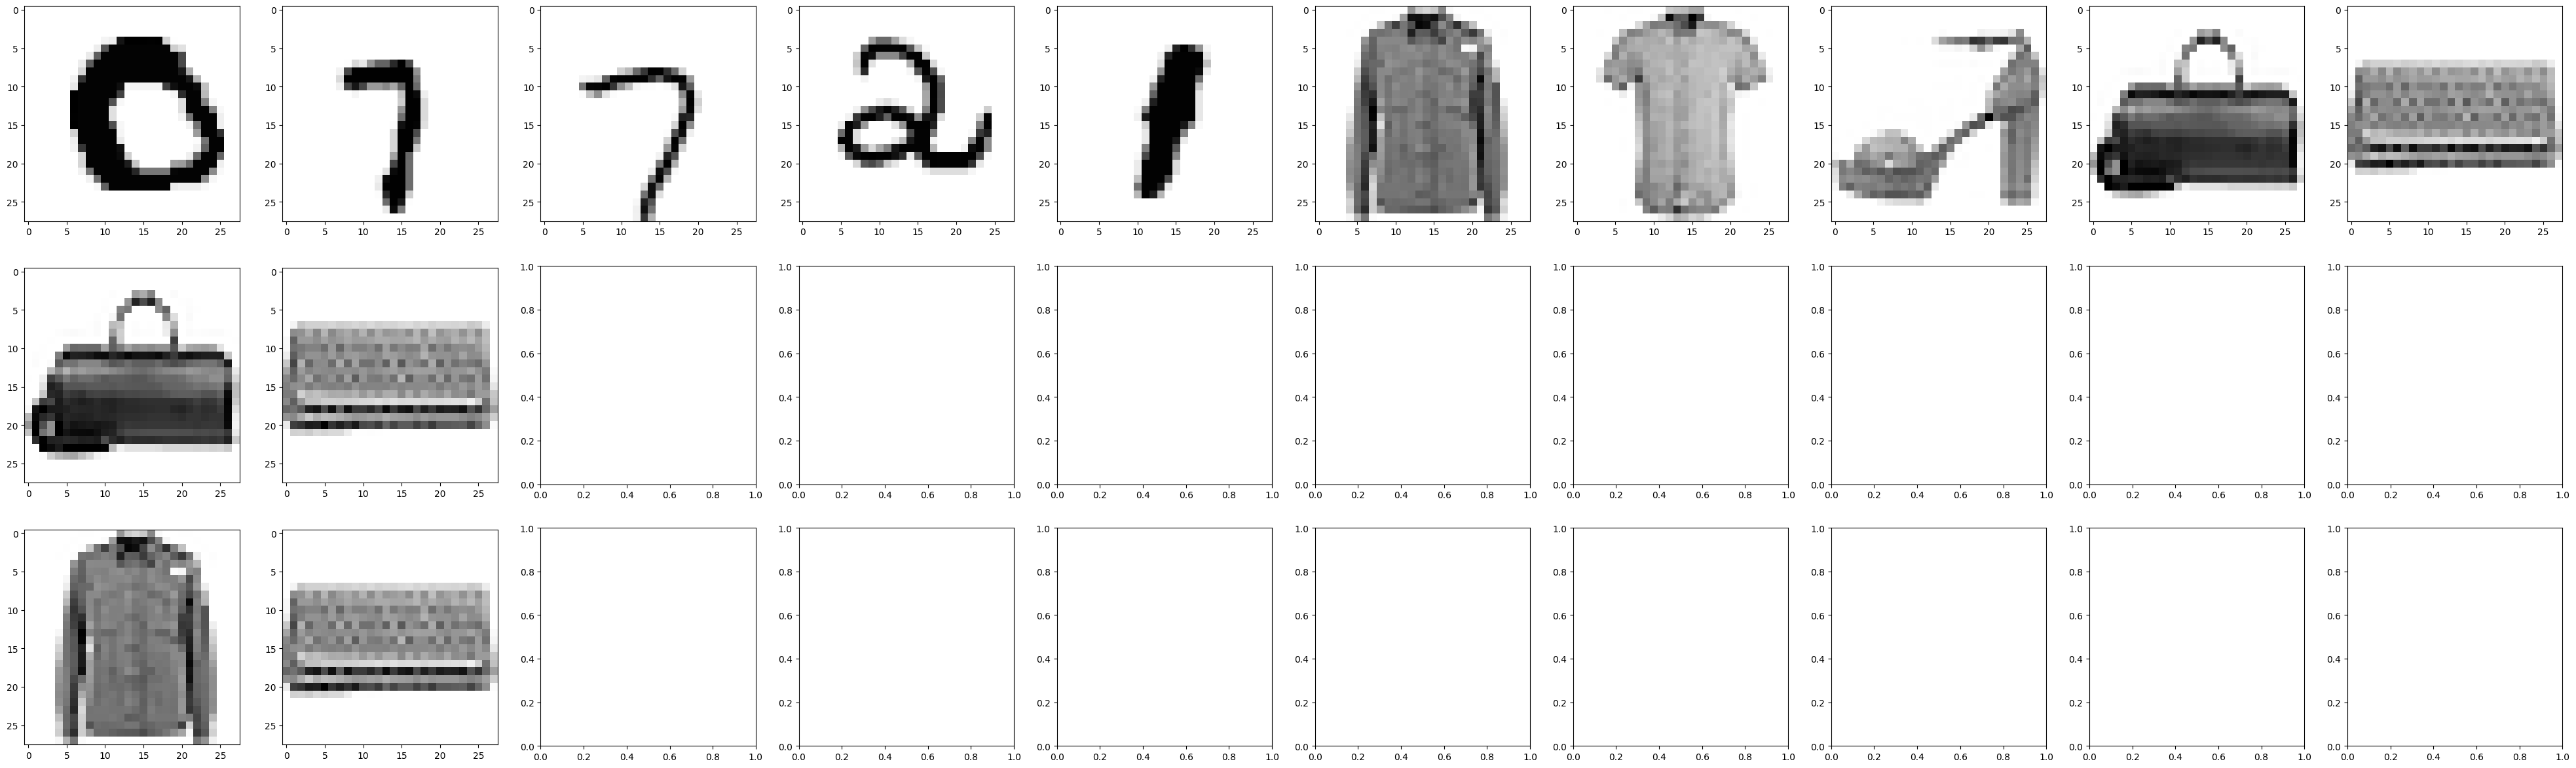

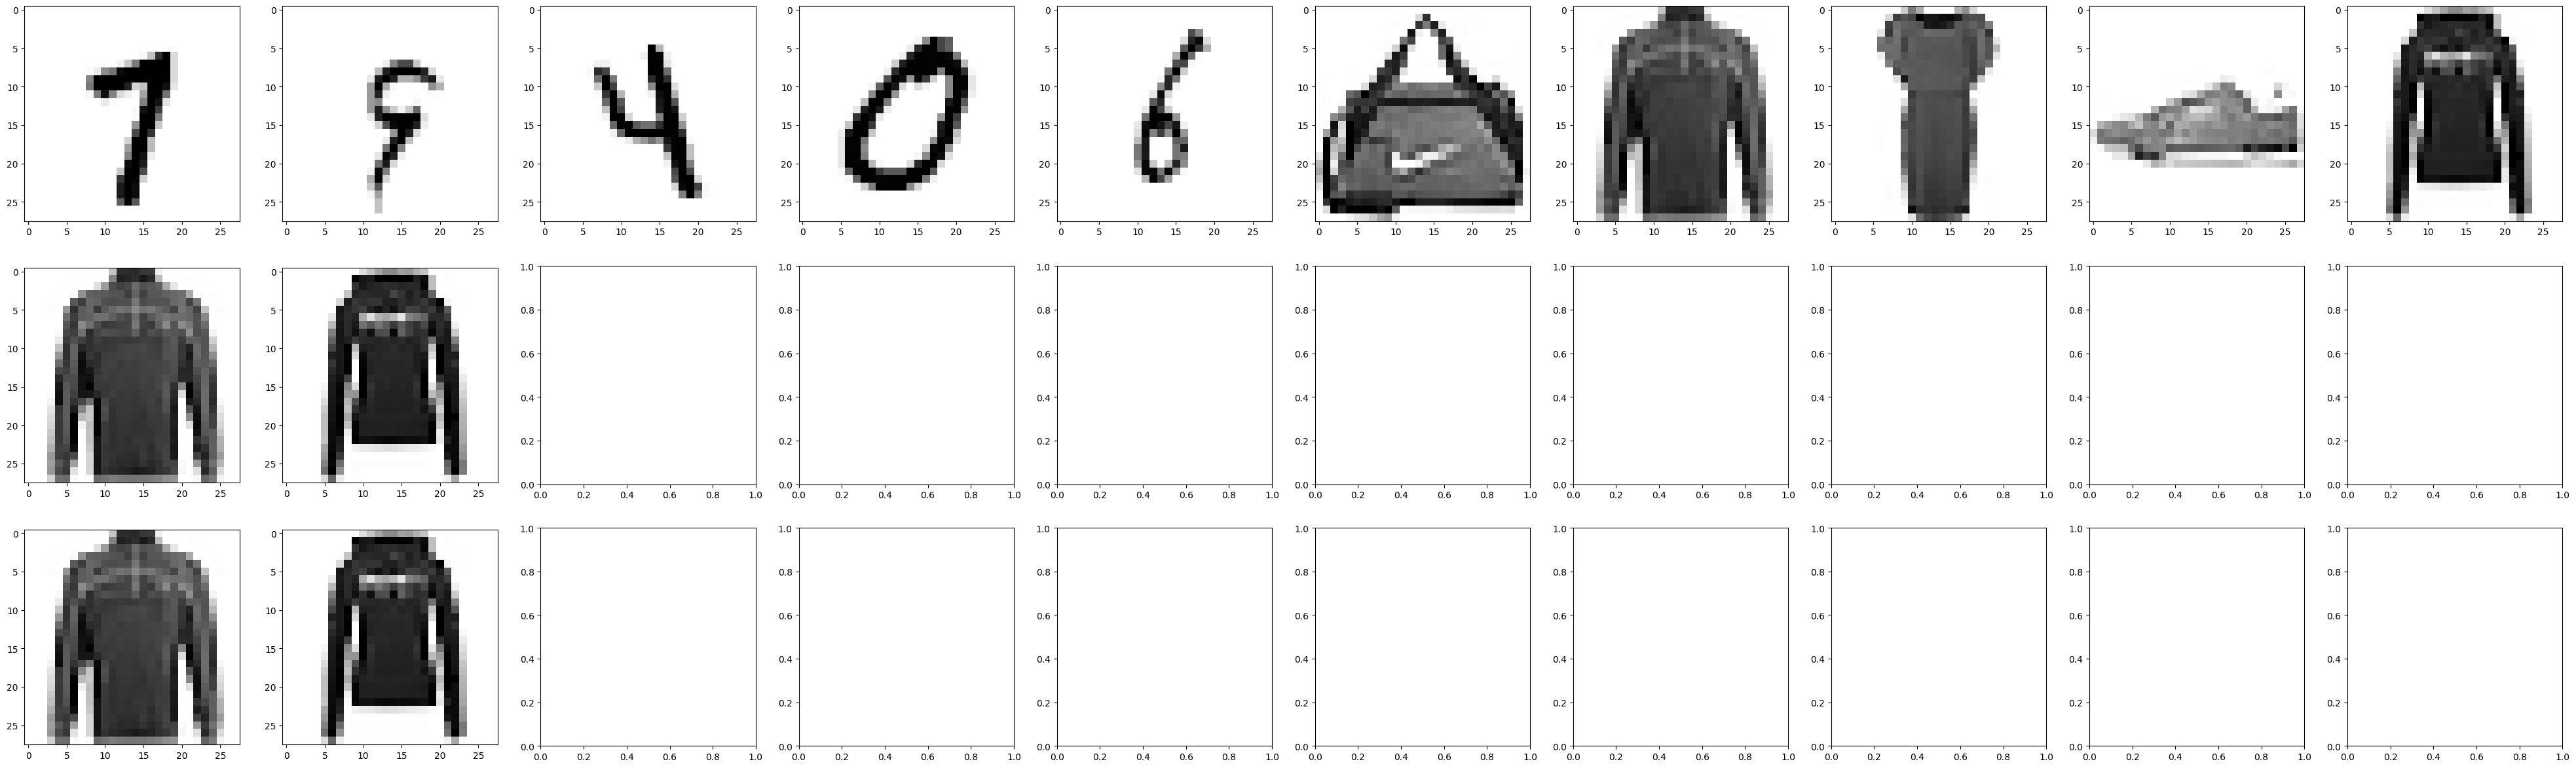

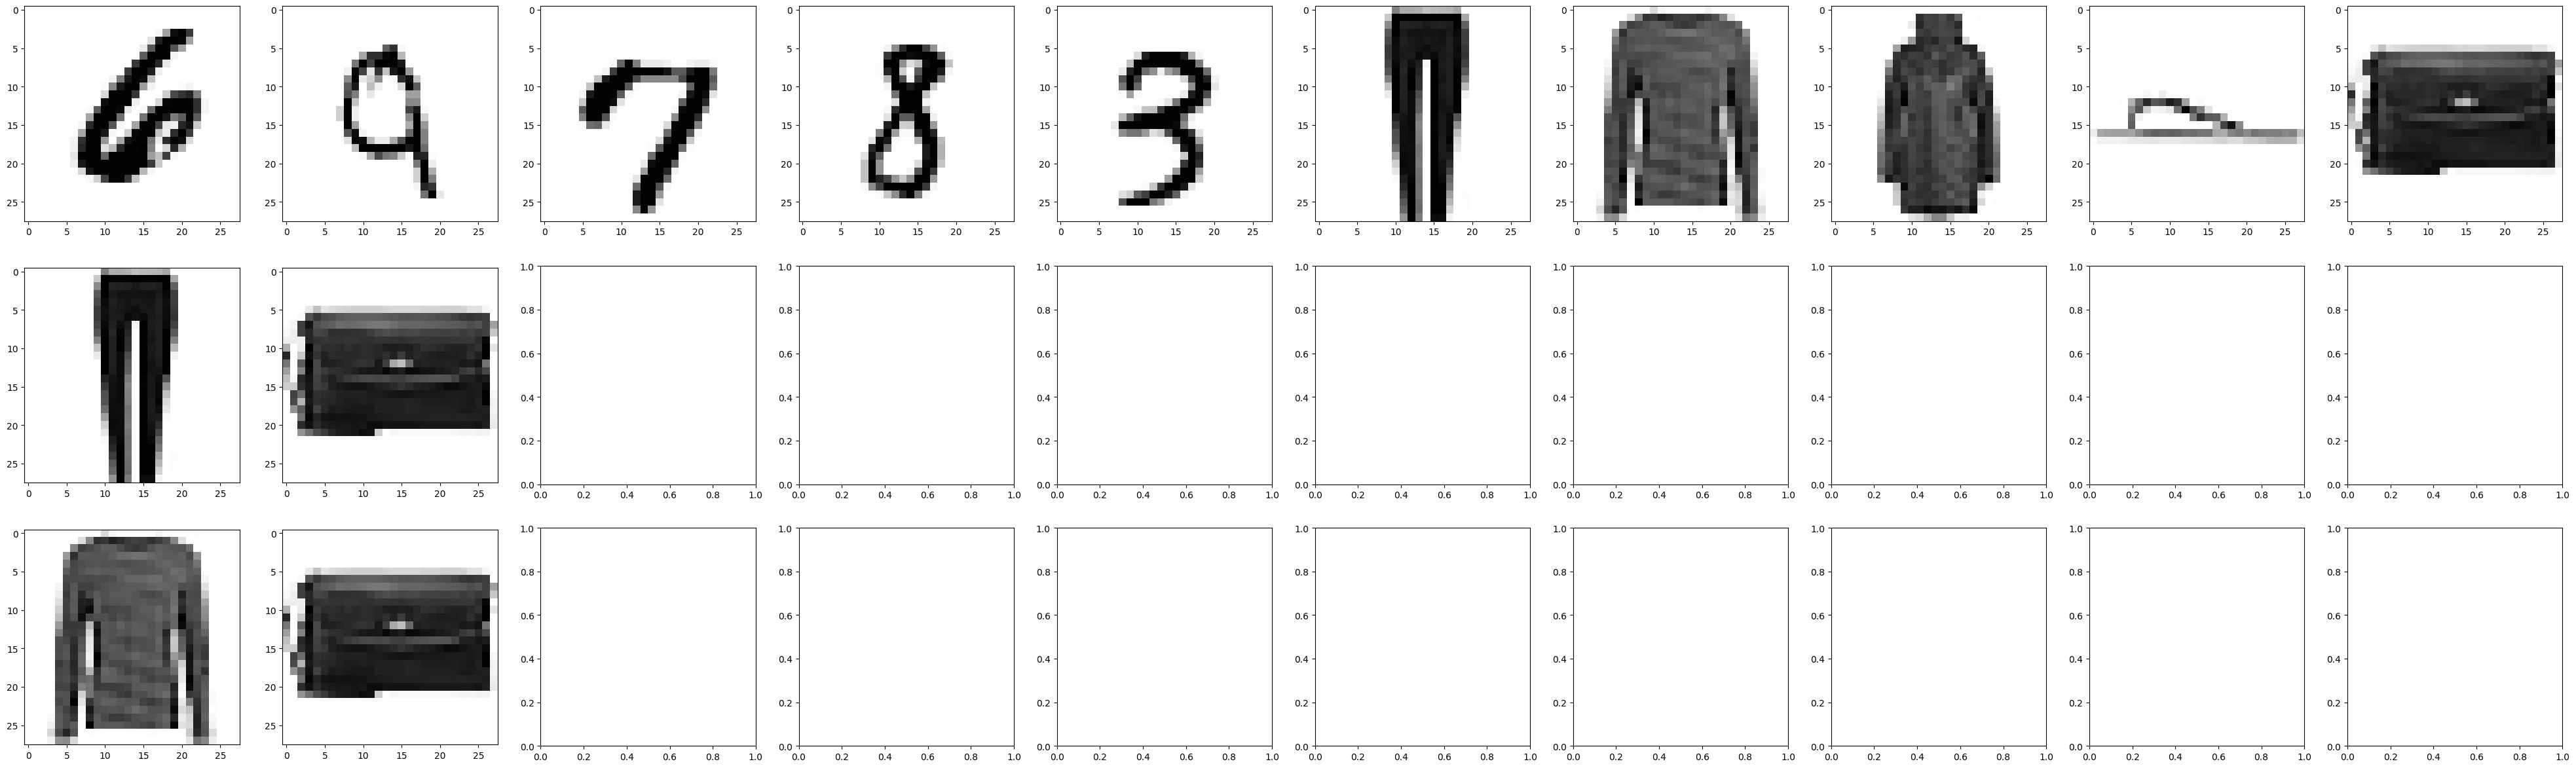

In [162]:
test_seq, labels, fnames, flags = alg_flags(algs_to_test, dataset_name, batch_size, num_batches, batch_compositions)
for i in range(num_batches):
    fig, axes = plt.subplots(len(algs_to_test)+1, batch_size, figsize=[5*batch_size, 5*(len(algs_to_test)+1)], dpi=100, squeeze=False)
    # Plot the full batch
    for j,ts in enumerate(test_seq[i]):
        plt_image(axes[0,j], ts)
    # Plot the subsampled points
    for k in range(len(algs_to_test)):
        ts_subset = [ts for (ts,flg) in zip(test_seq[i], flags[i][k]) if flg]
        for m,ts in enumerate(ts_subset):
            plt_image(axes[k+1,m], ts)

